# **Cargar dataset de imágenes en memoria utilizando OpenCV**
---

In [1]:
'''
REDES NEURONALES CONVOLUCIONALES (CNN)
Imagen y kernel -> 1º Convolución del kernel ->
-> 2º Relu -> 3º Max pooling ->
->4º Flattening -> Vector de características

1º Convolución del kernel: Se hace la convolución del kernel con la imagen
2º Relu: Los huecos negativos se ponen en 0
3º Max pooling: Se divide en bloques y se coge solo el máximo
4º Flattening: Se transforma la raiz resultante a un solo vector
'''
paths = ['/kaggle/input/brain-tumor-mri-dataset/Testing/',
         '/kaggle/input/brain-tumor-mri-dataset/Training/'
]

In [2]:
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt

In [3]:
#Transformamos las imágenes a escala de grises
def imshow(img):
    fig, ax = plt.subplots(1, 1, figsize = (8,8))
    ax.imshow(img, cmap = 'gray')

In [4]:
#Le decimos que coja las posibles etiquetas de testing
possible_labels = os.listdir(paths[0])

In [5]:
possible_labels

['pituitary', 'notumor', 'meningioma', 'glioma']

In [6]:
#Creamos un array que sea un dataset
data = []

#Para cada path (test [0] y train [1])
for i, path in enumerate(paths):
    #Para cada etiqueta (pituitary [0], notumor [1], meningioma [2], glioma [3])
    for label_int, label_string in enumerate(possible_labels):
        #Para cada archivo de esa etiqueta
        for filename in glob.glob(path+label_string+'/*.jpg'):
            #Lee la imagen
            img = cv2.imread(filename)
            #Añade al array otro array que relacione imagen con etiqueta
            #Como en las CNN todas las imágenes deben tener el mismo tamaño se resizea
            data.append( [label_int, cv2.resize(img, (320,320))] )

len(data)

7023

In [7]:
import random
#Baraja el array
random.Random(0).shuffle(data)
#Se inicializan los arrays de entrenamiento, validación y test
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

#Para cada array de [etiqueta, imagen] de data
for i, sample in enumerate(data):
    #Se coge la etiqueta
    label = sample[0]
    #Se coge la imagen
    img =sample[1]
    #Si está en el primer 80% del dataset
    if i <= 0.8 * len(data):
        #Se añaden al array de entrenamiento
        x_train.append(img)
        y_train.append(label)
    #Si está entre el 80% y el 90% del dataset
    elif i > 0.8 * len(data) and i <= 0.9 * len(data):
        #Se añaden al array de validación
        x_val.append(img)
        y_val.append(label)
    #Si está en el último 90% del dataset
    else:
        #Se añaden al aray de test
        x_test.append(img)
        y_test.append(label)

#Se transforman a arreglos de numpy
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

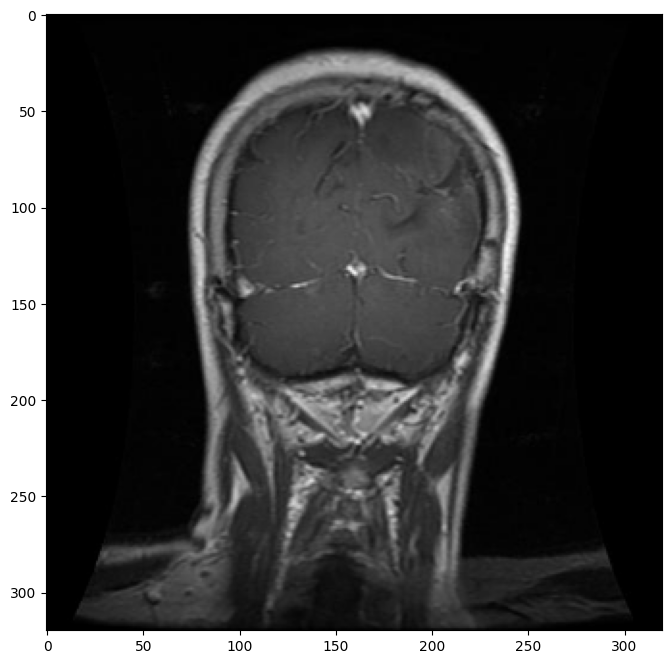

In [8]:
imshow(x_train[0])

In [9]:
possible_labels[y_train[0]]

'glioma'

# **Definición y entrenamiento de la red neuronal convolucional**
---

In [10]:
import tensorflow as tf
y_trainOneHot = tf.one_hot(y_train, len(possible_labels))
y_valOneHot = tf.one_hot(y_val, len(possible_labels))
y_testOneHot = tf.one_hot(y_test, len(possible_labels))

2025-10-07 16:32:50.734355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759854770.911180      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759854770.967604      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1759854782.983573      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759854782.984247      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

In [32]:
#Instanciamos la red neuronal convolucional
def cnn_model():
    model = Sequential()
    #1º Convolución del kernel (32 kernels de 3x3 cada uno)
    #Se van a tomar imágenes de 320x320 con 3 canales (escala de grises)
    model.add(Input(shape=(320, 320, 3)))  # <-- ESTA ES LA CLAVE
    #2º Se aplica relu como activación para que los números negativos se queden a 0
    model.add(Conv2D(32,(3,3), activation = 'relu'))
    #3º Se hace max pooling para coger el mayor valor de una ventana de 2x2
    model.add(MaxPooling2D(pool_size = (2,2)))
    #4º Se aplica flatten para transformarlo todo en un solo vector
    model.add(Flatten(name = 'feat_flatten'))
    #Definimos la red neuronal normal
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(4, activation = 'softmax'))
    #Compilamos la red neuronal
    model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [36]:
#Llamamos al modelo
model = cnn_model()
#Da un resumen
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feat_flatten (Flatten)          │ (None, 808992)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │    24,269,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,270,810 (92.59 MB)

 Trainable params: 24,270,810 (92.59 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Los callbacks son código que se ejecuta mientras el modelo entrena
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

#En cada iteración (época) vamos a tener distintos pesos
#Con un checkpoint guarda los pesos de cada época en un archivo
#model.1.h5 model.2.h5 model.3.h5 ...
#Si save_best_only = True solo guardará el mejor modelo según una métrica
checkpoint = ModelCheckpoint(
    'checkpoint/model.{epoch:d}.h5',
    save_best_only = False,
    save_freq = 'epoch'
)

#Guarda registros del entrenamiento que luego podremos ver con Tensorboard
#Si histogram_freq = 1 guardará histogramas cada 1 época
tensorboard_callback = TensorBoard('logs/cnn_logs', histogram_freq = 1)

In [15]:
x_train.shape

(5619, 320, 320, 3)

In [16]:
x_val.shape

(702, 320, 320, 3)

In [17]:
model.fit(x_train,
          y_trainOneHot,
          epochs = 20,
          batch_size = 100,
          validation_data = (x_val, y_valOneHot),
          callbacks = [tensorboard_callback, checkpoint]
         )

Epoch 1/20


I0000 00:00:1759854789.841230     106 service.cc:148] XLA service 0x7e1ce0006780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759854789.842963     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759854789.843038     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759854789.993322     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759854796.248498     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 300ms/step - accuracy: 0.2325 - loss: 17515.0195 - val_accuracy: 0.3134 - val_loss: 1.3855
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.2784 - loss: 1.3857 - val_accuracy: 0.3134 - val_loss: 1.3841
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.2892 - loss: 1.3847 - val_accuracy: 0.3134 - val_loss: 1.3829
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.2809 - loss: 1.3847 - val_accuracy: 0.3134 - val_loss: 1.3819
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.2780 - loss: 1.3844 - val_accuracy: 0.3134 - val_loss: 1.3812
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.2872 - loss: 1.3835 - val_accuracy: 0.3134 - val_loss: 1.3806
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.2790 - loss: 1.3842 - val_accuracy: 0.3134 - val_loss: 1.3801
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.2880 - loss: 1.3831 - val_accuracy: 0

# **Predicción y evaluación del modelo sobre el dataset de prueba**
---

In [18]:
'''
x_test[0:1] 
model.predict() espera un array con esta forma (10000, 320, 320, 1)
x_test[0] devuelve (320, 320, 1) porque devuelve solo una imagen, por
eso x_test[0:1] devuelve (1, 320, 320, 1)
model.predict(...)
Predice las probabilidades de algo de que sea un tumor u otro y
devuelve algo así array([[0.01, 0.02, 0.85, 0.12]])
np.argmax(...)
Devuelve el argumento mayor de ese array, es decir, el de
mayor probabilidad
possible_labels[...] evalua en este array de opciones
'''
possible_labels[np.argmax(model.predict(x_test[0:1]))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'notumor'

In [19]:
possible_labels[y_test[0]] #Coinciden

'notumor'

In [20]:
model.evaluate(x = x_test, y = y_testOneHot)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.3001 - loss: 1.3816


[1.3849732875823975, 0.27635326981544495]

# **Tensorboard para escoger el mejor modelo**
---

In [21]:
#Hacemos una parte en google colab y luego ponemos el modelo que más precisión tenga
model.load_weights('./checkpoint/model.19.h5')

In [22]:
model.evaluate(x = x_test, y = y_testOneHot)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3001 - loss: 1.3816


[1.3849713802337646, 0.27635326981544495]